In [ ]:
import time
import nltk
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
from plotly.offline import iplot

In [ ]:
!pip3 install wordcloud

     |████████████████████████████████| 366 kB 24.5 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


### Import data

In [ ]:
data = pd.read_csv('data/train.csv')

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426340 entries, 0 to 426339
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      426340 non-null  int64 
 1   ProductId               426340 non-null  object
 2   UserId                  426340 non-null  object
 3   ProfileName             426326 non-null  object
 4   HelpfulnessNumerator    426340 non-null  int64 
 5   HelpfulnessDenominator  426340 non-null  int64 
 6   Score                   426340 non-null  int64 
 7   Time                    426340 non-null  int64 
 8   Summary                 426320 non-null  object
 9   Text                    426340 non-null  object
dtypes: int64(5), object(5)
memory usage: 32.5+ MB
None


In [ ]:
data.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

In [ ]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,426340.000000,426340.000000,426340.000000,426340.000000,4.263400e+05
mean,284300.799618,1.733159,2.220244,4.183455,1.296222e+09
std,164012.600602,7.328184,8.014894,1.310577,4.808061e+07
min,1.000000,0.000000,0.000000,1.000000,9.408096e+08
25%,142363.750000,0.000000,0.000000,4.000000,1.271203e+09
50%,284308.500000,0.000000,1.000000,5.000000,1.311034e+09
75%,426183.250000,2.000000,2.000000,5.000000,1.332720e+09
max,568454.000000,844.000000,923.000000,5.000000,1.351210e+09


In [ ]:
print('Number of unique products:', len(data['ProductId'].unique()))
print('Number of unique users:', len(data['UserId'].unique()))
print('Number of unique reviews:', len(data['Text'].unique()))
print('Number of unique summaries:', len(data['Summary'].unique()))



Number of unique products: 63294
Number of unique users: 209987
Number of unique reviews: 308235
Number of unique summaries: 234596


#### Check for null/empty values 

In [ ]:
nulls = data.isnull().sum()
nulls[nulls > 0]

ProfileName    14
Summary        20
dtype: int64

We will remove rows where any column value is empty/null

In [ ]:
data = data.dropna() # Remove all rows with NaN values

# Recheck for nulls
nulls = data.isnull().sum()
nulls[nulls > 0]

Series([], dtype: int64)

We have no more empty data

### Analyze score distribution

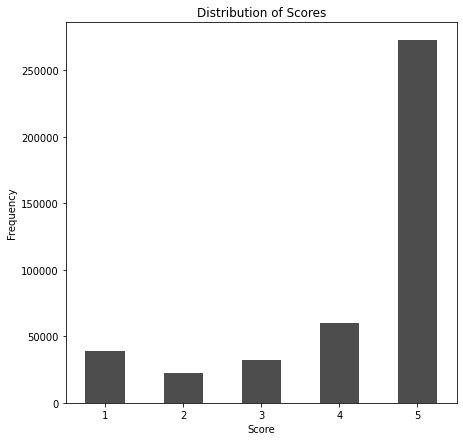

In [ ]:
# Columns to analyze with histograms
data.Score.value_counts().sort_index().plot(
    kind='bar',
    color='0.3',
    figsize=(7,7)
)
plt.title('Distribution of Scores')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.xticks(rotation=0) # set axis rotation to normal
plt.show()

We can see that the reviews are overwhelmingly 5 star rated. This may impose a bias on our model due to the uneven distribution of our training data.

In [ ]:
from wordcloud import WordCloud, STOPWORDS 

In [ ]:
data['date'] = pd.to_datetime(data['Time'],unit='s')
date_data = data[['date','Score']]
date_data.date = date_data.date.dt.strftime('%Y-%m-%d')
date_data = date_data.sort_values(by=['date'])
date_data.head()

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyboardInterrupt: 

### Analyze helpfulness score

#### Generate a column for helpfulness score 

In [ ]:
# Calculate the helpfulness
data['Helpfulness'] = data['HelpfulnessNumerator']/data['HelpfulnessDenominator']
# For scores where the denominator was 0, replace NaN with zeros
data['Helpfulness'] = data['Helpfulness'].fillna(0)
data[['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness']].head()

,HelpfulnessNumerator,HelpfulnessDenominator,Helpfulness
0,0,0,0.0
1,1,1,1.0
2,0,0,0.0
3,0,0,0.0
4,0,0,0.0


In [ ]:
data['Helpfulness'].describe()

count    426306.000000
mean          0.407614
std           0.461951
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           3.000000
Name: Helpfulness, dtype: float64

Strangely, the maximum helpfulness score is greater than one, at 3. This is impossible since the helpfulness score is the fraction of people that found the review helpful, therefore it cannot be higher than one. Let's look at the entries that have a helpfulness score above 1:

In [ ]:
data[data['Helpfulness']>1][
    ['HelpfulnessNumerator',
     'HelpfulnessDenominator', 
     'Helpfulness']
]

,HelpfulnessNumerator,HelpfulnessDenominator,Helpfulness
104703,3,1,3.0


There is one entry, where the numerator is higher than the denominator, we will remove this entry from our data.

In [ ]:
# Remove all entries (actually just one) where the helpfulness score is above 1
data = data[data.Helpfulness <= 1]

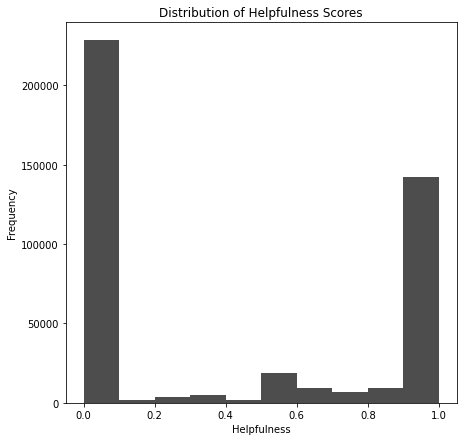

In [ ]:
# Columns to analyze with histograms
data['Helpfulness'].hist(bins=10, figsize=(7,7), color='0.3')
plt.title('Distribution of Helpfulness Scores')
plt.ylabel('Frequency')
plt.xlabel('Helpfulness')
plt.grid(b=None) # disable grid
plt.show()

#### Analyze String field lengths by number of words

In [ ]:
data["summary_size"] = data['Summary'].apply(lambda x: len(str(x).split(' ')))
data["text_size"] = data['Text'].apply(lambda x: len(str(x).split(' ')))

In [ ]:
data[['Summary', 'summary_size', 'Text', 'text_size']].head()

,Summary,summary_size,Text,text_size
0,Very Good,2,I received this product early from the seller!...,38
1,"Organic, Kosher, Tasty Assortment of Premium T...",9,*****<br />Numi's Collection Assortment Melang...,310
2,"excellent gluten-free spaghetti: great taste, ...",7,"I was very careful not to overcook this pasta,...",197
3,Lindt is Lindt,3,Buying this multi-pack I was misled by the pic...,31
4,YUM!!!!!,1,These bars are so good! I loved them warmed up...,28


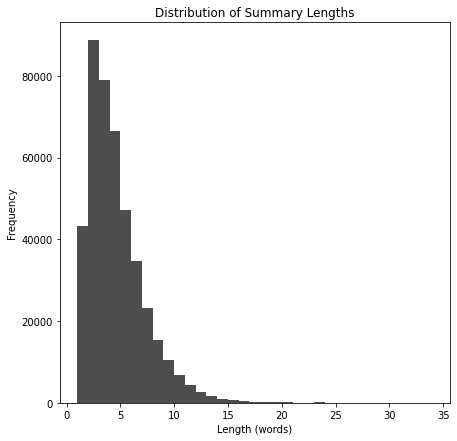

In [ ]:
# Columns to analyze with histograms
unique_vals = data['summary_size'].unique()
data['summary_size'].hist(bins=len(unique_vals), figsize=(7,7), color='0.3')
plt.title('Distribution of Summary Lengths')
plt.ylabel('Frequency')
plt.xlabel('Length (words)')
plt.grid(b=None) # disable grid
plt.show()

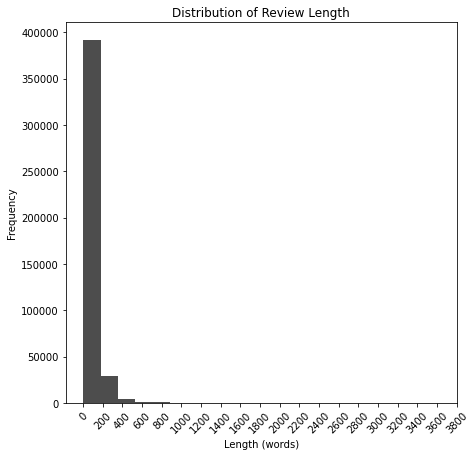

count    426305.000000
mean         81.863086
std          80.502554
min           3.000000
25%          34.000000
50%          58.000000
75%         100.000000
max        3526.000000
Name: text_size, dtype: float64

In [ ]:
# Columns to analyze with histograms
data['text_size'].hist(bins=20, figsize=(7,7), color='0.3')
plt.title('Distribution of Review Length')
plt.ylabel('Frequency')
plt.xlabel('Length (words)')
plt.xticks(range(0, 4000, 200), rotation=45)
plt.grid(b=None) # disable grid
plt.show()

data['text_size'].describe()

We can see that whereas most reviews are 100 words or shorter, there are some that are incredibly long, with the largest having 3,526 words. We will examine how many reviews are large (larger than 1,000 words)

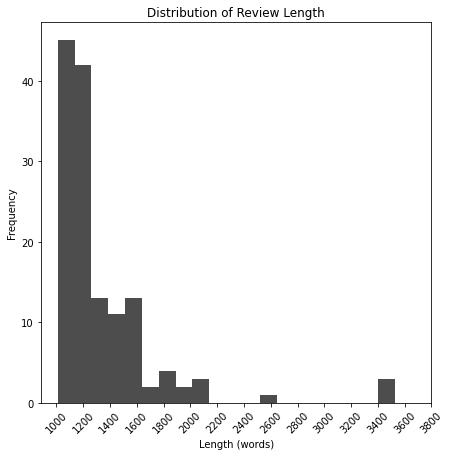

count     139.000000
mean     1343.115108
std       423.588262
min      1009.000000
25%      1109.000000
50%      1212.000000
75%      1451.000000
max      3526.000000
Name: text_size, dtype: float64

In [ ]:
temp_data = data[data['text_size']>1000]
# Columns to analyze with histograms
temp_data['text_size'].hist(bins=20, figsize=(7,7), color='0.3')
plt.title('Distribution of Review Length')
plt.ylabel('Frequency')
plt.xlabel('Length (words)')
plt.xticks(range(1000, 4000, 200), rotation=45)
plt.grid(b=None) # disable grid
plt.show()

temp_data['text_size'].describe()

There seem to be an unusually large number of reviews that have > 3400 words, let's analyze this.

In [ ]:
large_reviews = data[data.text_size > 3000]
large_reviews.text_size.describe()

count       3.0
mean     3526.0
std         0.0
min      3526.0
25%      3526.0
50%      3526.0
75%      3526.0
max      3526.0
Name: text_size, dtype: float64

There seems to be 3 entries with the exact same number of words, let's look at them

In [ ]:
large_reviews[['ProductId', 'UserId', 'Text', 'text_size']]

,ProductId,UserId,Text,text_size
21756,B005HG9ESG,A24HWYHR28JJ7A,Fuzzy Wuzzy's Summary:<br />*** Somewhat recom...,3526
66592,B005HG9ET0,A24HWYHR28JJ7A,Fuzzy Wuzzy's Summary:<br />*** Somewhat recom...,3526
175574,B005HG9ERW,A24HWYHR28JJ7A,Fuzzy Wuzzy's Summary:<br />*** Somewhat recom...,3526


We can see that this user has left the exact same review on three different products. How many other reviews have been repeated?

In [ ]:
counts = data.groupby('Text').size().reset_index(name='count')
counts[counts['count']>1].sort_values('count', ascending=False)

,Text,count
265760,"This review will make me sound really stupid, ...",140
22744,Diamond Almonds<br />Almonds are a good source...,94
84958,"I have two cats, one 6 and one 2 years old. Bo...",41
215118,The pet food industry can be one of the most i...,37
136541,"I'm addicted to salty and tangy flavors, so wh...",32
...,...,...
93613,"I love a strong hazelnut flavor, but this KCup...",2
200119,"Smell good, nice texture, but i am a little di...",2
93648,"I love all of Chef Paul seasonings. Poultry, V...",2
93661,I love all of the Blue Diamond Almond flavors ...,2


We've discovered that 46,054 reviews have duplicates, with one even having as many as 140 duplicates.

In [ ]:
data.shape

(426305, 13)

In [ ]:
data.drop_duplicates(subset='Text', keep='first', inplace=True)
data.shape

(308235, 13)

We have removed 118,070 duplicated entries

In [ ]:
counts = data.groupby('Text').size().reset_index(name='count')
counts[counts['count']>1].sort_values('count', ascending=False)

,Text,count


We can see that we do not have any more duplicates

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5f7cd34f-fff5-42b6-b8d8-aed6c2192391' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>